# OWA Dudgeon Benchmark: Input data


## WRF Mesoscale Simulation
The mesoscale simulation has been produced adopting most of the WRF settings that has been used to produce the production run of the New European Wind Atlas (NEWA). Three one-way nested domains of 27, 9 and 3 km resolution are configured centred at the wind farm centroid (56.6ºN; 11.2ºE). The vertical grid has 61 terrain-following (sigma) levels, with 10 levels covering the first 200 meters, more specifically at: 6, 22, 40, 56, 73, 90, 113, 140, 179 and 205 meters. High resolution topography (SRTM 90m) and updated land use categories (Corine Land Cover 2018), together with the Noah land-surface model are used to define the boundary conditions at the surface. The physical parameterizations are: Mellor–Yamada–Nakanishi Niino 2.5-level planetary boundary-layer scheme (MYNN), WRF Single-Moment 5-class microphysics scheme, the Rapid Radiative Transfer Model for GCMs shortwave and longwave radiation schemes and the Kain-Fritsch cumulus scheme in the outermost domains 1 and 2. The simulation is driven by input data from ERA-5 in blocks of 5 days with additional spin-up time of 24 hours.    

## Load libraries and constants

In [2]:
%matplotlib inline
import sys
sys.path.append('../')

from src.WindConditions import *
from src.BinAvrg import * 

## Reference site 
In the absence of an *undisturbed* met mast, the wind farm centroid is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. This site has also been used as the center of the innermost domain in the WRF set-up.   

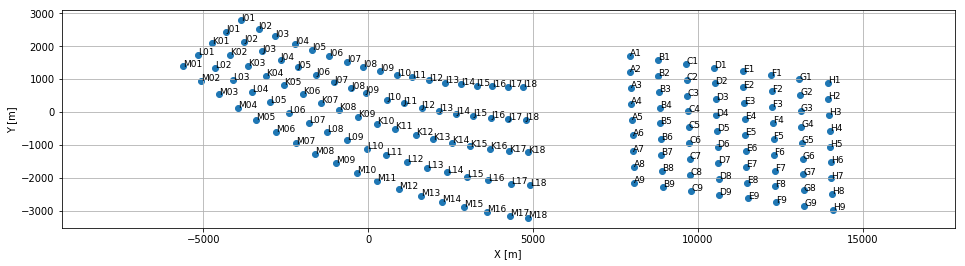

In [3]:
siteID = 'Rodsand2'
Hhub = 68.5         # hub-height
Drot = 82.4          # rotor diameter
zref = Hhub         # [m] 

# Load wind farm layout data
turbines_Rodsand2 = pd.read_csv("inputs/Rodsand2_layout.csv")
turbines_Nysted = pd.read_csv("inputs/Nysted_layout.csv")
turbines = pd.concat([turbines_Rodsand2, turbines_Nysted]).reset_index(drop=True)

x_ref, y_ref = centroid(turbines_Rodsand2[['X coordinate','Y coordinate']].values)

plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,labels = turbines['VDC ID'],figsize=[16,4])

In [4]:
x_ref, y_ref

(664492.6111111111, 6048460.133333334)

## Evaluation period 
The evaluation period shall correspond to the span of the SCADA data. The evaluation will be based on hourly data, which is the sampling time of the mesoscale simulations. With hourly data we guarantee that all wind turbines are experiencing slow-varying wind conditions, i.e. there is sufficient time for mesoscale variability to be advected accross the wind farm (it takes one hour for air traveling at 7,5 m/s to cover 27 km). 
The *flags* dataframe indicates which timestamps have been filtered out in the quality-control process of the SCADA data. This will allow to perform the evaluation on validation dataset which only contains situations where the wind farm is operating in normal conditions.  

In [5]:
datefrom = time_stamp(2013,2,1,0,0,0)    # evaluation period
dateto = time_stamp(2014,6,30,23,0,0)    # evaluation period

## Load horizontaly averaged vertical profiles at the reference site
An area of 27x27 km² centered at the reference site has been used to produce horizontaly averaged vertical profiles that are representative of the vertical structure of the atmospheric boundary layer (ABL) accross the wind farm. Surface-layer quantities and mesoscale tendencies are also provided to define a set of boundary conditions and forcings for microscale models that assume horizontally-homogeneous inflow conditions.  

In [6]:
mast = WindConditions('./inputs/Rodsand2_Control_Lav30km_ref.nc',lat_ref, lon_ref, siteID, datefrom, dateto)

NameError: name 'lat_ref' is not defined

### Time series
Select a period to plot time series of reference quantities.  

In [ ]:
# Select a period
datefromplot = time_stamp(2013,6,30,0,0,0)
datetoplot = time_stamp(2013,7,2,23,50,0)

mast.plot_timeseries(datefromplot,datetoplot,zref)

### Time-height contours
The structure of the ABL can be visualized here in terms of velocity components and momentum tendencies. As a reference, we indicate the vertical span of the wind turbine rotor and plot in log scale to have a clearer view of the whole ABL depth extending from a few hundred meters in stable conditions to around a thousand meters in unstable conditions. 

In [ ]:
# Same period as it was defined for the time series
yrotor1 = np.array([Hhub - 0.5*Drot, Hhub - 0.5*Drot])
yrotor2 = np.array([Hhub + 0.5*Drot, Hhub + 0.5*Drot])
zlim = 4000.0   # top height of the plot

mast.plot_ABL(datefromplot,datetoplot,zlim,yrotor1,yrotor2)

### Wind Climate Distributions
Distributions in terms of wind speed, direction and stability bins. 

In [ ]:
mast.plot_windrose(zref)

In [ ]:
#WDbins = np.arange(-11.25,360.+11.25,22.5) # wind direction bins (16 sectors)
#WDbins_label = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
#                'S','SSW','SW','WSW','W','WNW','NW','NNW']
#zLbins = [-20,-2, -0.6, -0.2, -0.02, 0.02, 0.2, 0.6, 2, 20] # 9 stability bins
#zLbins_label = ['xu','vu','u','wu','n','ws','s','vs','xs']

WDbins = np.arange(-15.,360.+15.,30) # wind direction bins (12 sectors)
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
zLbins = [-20,-0.6,-0.02, 0.02, 0.6, 20] # 5 stability bins
zLbins_label = ['vu','u','n','s','vs']

### Plot stability per wind direction sector
N_WDzL,N_SzL,N_zL,N_WD,S_WDzL = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

You can get the distributions in tabulated form by simply calling the corresponding dataframe.
- *N_WDzL*: number of samples per wind direction and stability class
- *N_SzL*: number of samples per wind speed and stability class
- *N_zL*: number of samples per stability class
- *N_WD*: number of samples per wind direction sector

You can also visualize the mean wind speed per bin using the table *S_WDzL*.

Note that we will use *N_WDzL* distribution to weight array efficiency for each bin and compute the total array efficiency for the evaluation period.

In [ ]:
N_WDzL

### Select wind conditions for a stronger wake-effect signal
Previous distribution includes all wind speeds. A stronger signal of wake effects will be obtained when the turbines operate around the maximum of the thrust coefficient, say around 9 m/s.  

In [ ]:
min_S = 8
max_S = 10

N_WDzL,N_SzL,N_zL,N_WD,S_WDzL = mast.analyse_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref,min_S,max_S)

In [ ]:
N_WDzL

In [ ]:
S_WDzL